# NLP & W2VEC

In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


In [2]:
data = pd.read_csv("./data/data1671694184.csv")
data = data[['message', 'category']]

In [3]:
data.head()

,message,category
0,positionผมได้วิเคราะห์ไว้แล้ว,A
1,ท็อปเสดละขอมั่ง,A
2,ก่อนงานอันใหญ่,A
3,อย่าลืมพิมพ์เอกสาร แล้วก็แลปชีทของแลปฮาร์ดกันม...,A
4,มีทำแบบฝึก3 ตอบคำถามจากpointและวิดีโอศึกษาชุมช...,A


### Data Features and Values

In [4]:
def clean_data(data):
    # filter common chat
    # data = data.drop(data.index[ data['category'] == 'C' ])
    # sort data by category
    data = data.sort_values(by=['category'])

    data = data.reset_index()
    data = data[['message', 'category']]

    return data

In [5]:
data = clean_data(data)

In [6]:
category_list = data['category'].unique()
category_list

array(['A', 'C', 'Q', 'S', 'T'], dtype=object)

In [7]:
data.shape

(15712, 2)

In [8]:
data.dtypes

message     object
category    object
dtype: object

In [9]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

In [10]:
def plot_count_graph():
    count_graph = sns.countplot(data.category)
    count_list = []

    for p in count_graph.patches:
        height = p.get_height()
        count_list.append(height)
        count_graph.annotate('{:.1f}'.format(height), (p.get_x()+0.25, height+0.01))

    plt.show()

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


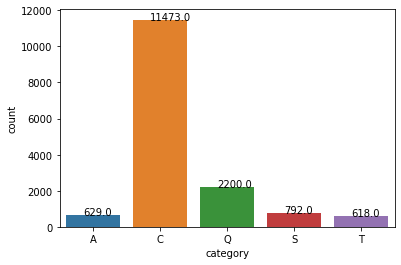

In [11]:
plot_count_graph()

### Balancing Category

In [12]:
df_list = []
for category in category_list:
    df_list.append(data.query(f"category == '{category}'").sample(
        n=600,
        replace=False, #True if numbers of sample higher than minimum numbers of category
        random_state=18, 
        )
    )

data = clean_data(data= pd.concat(df_list))

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


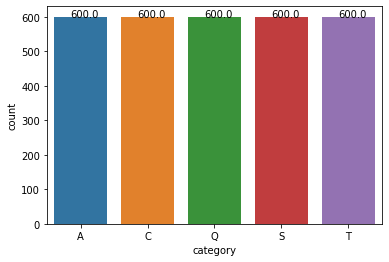

In [13]:
plot_count_graph()

In [14]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0       42
1       50
2       18
3       30
4       23
        ..
2995    38
2996    14
2997    26
2998    22
2999    30
Name: message_length, Length: 3000, dtype: int64


### Words Distribution Plot

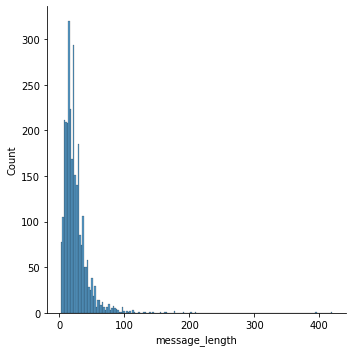

In [15]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [16]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [17]:
words_category = []
for category in category_list:
    words_category.append(count_words(category))

words_category

[987, 1081, 876, 930, 936]

In [18]:
print('Total Word:')
print(count_words())

Total Word:
2518


<AxesSubplot:xlabel='category', ylabel='words_count'>

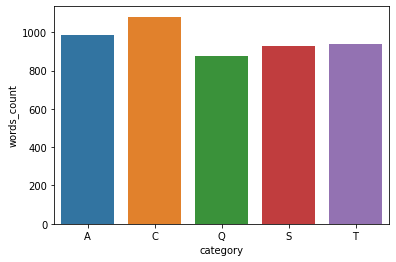

In [19]:
words_count = {'category': category_list, 'words_count': words_category}
w_count_data = pd.DataFrame(words_count)
sns.barplot(x= 'category', y='words_count', data=w_count_data)

### Word Cloud

In [20]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [21]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

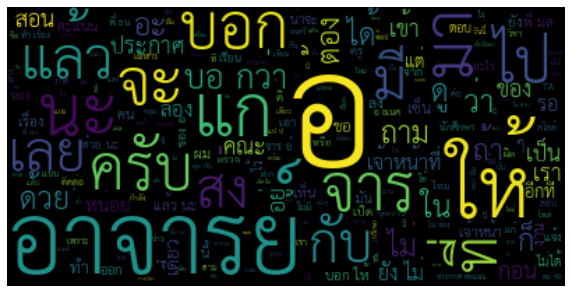

In [22]:
check_wordcloud('T')

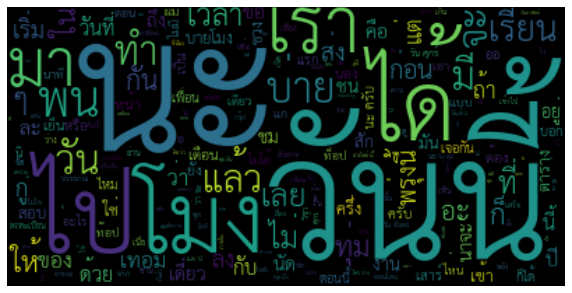

In [23]:
check_wordcloud('S')

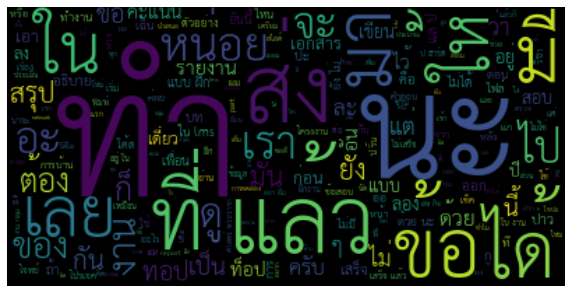

In [24]:
check_wordcloud('A')

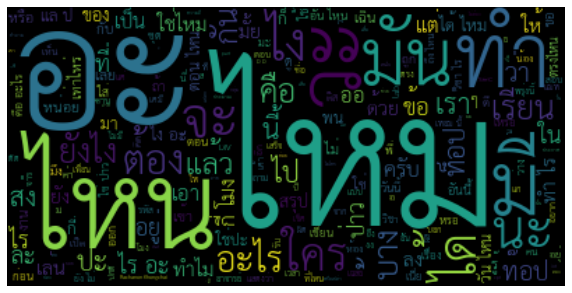

In [25]:
check_wordcloud('Q')

### Label Encoding

In [26]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [27]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)


     category  category_target
0           A                0
600         C                1
1200        Q                2
1800        S                3
2400        T                4


In [28]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")
json_file = 'classes.json'

# Writing to .json
with open(json_file, "w") as outfile:
    outfile.write(json_classes)


In [29]:
# Opening JSON file
with open(json_file, 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [30]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [31]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'C', 'Q', 'S', 'T']


### Word2Vec

In [32]:
w2v_thai = WordVector()

In [33]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [34]:
X = np.array(word2vec).tolist()

data['word2vec'] = X


In [35]:
# reshape
data_reshape = np.reshape(X, (-1, 300))

In [36]:
print(data_reshape.shape)

(3000, 300)


In [37]:
data.head()

,message,category,message_length,category_target,word2vec
0,ได้ๆ แต่เราต้องทำเรื่องกักตัวสอบด้วยนะเฉิน,A,42,0,"[[-0.13755091938834924, -0.19850869075610086, ..."
1,ที่แบ่งไปจะได้ทำเต็มที่งานชิ้นนี้ประมาณ70%ของค...,A,50,0,"[[-0.1279377986987432, -0.12541006691753864, 0..."
2,ของท๊อปทำประมาณนี้,A,18,0,"[[0.01532459855079651, -0.1748829960823059, 0...."
3,มันมีแลปที่เราต้องสอบปฏิบัติมะ,A,30,0,"[[-0.07623060196638107, -0.06555030420422554, ..."
4,เกรดวิชาฝึกงานออกแล้วนะ,A,23,0,"[[-0.23433899941543737, -0.09317749676605065, ..."


# AI MODEL

### Split the data in Training and Testing

In [38]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(3000, 300)

In [40]:
# Normalize the data
from sklearn.preprocessing import normalize

data_reshape = normalize(data_reshape)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    random_state=18,
                                                    test_size = 0.2,
                                                    shuffle=True
                                                    )

In [43]:
print(X_train.shape)
print(y_train.shape)

(2400, 300)
(2400,)


In [44]:
print(X_test.shape)
print(y_test.shape)

(600, 300)
(600,)


### Models Predictions

In [84]:
# RandomForest Model
rf_model = RandomForestClassifier(
    n_estimators= 900,
    # max_depth= 180,
    # min_samples_split= 2,
    bootstrap= False,
    # criterion= 'entropy',
    )
rf_model.fit(X_train, y_train)

accuracy_predictions = rf_model.predict(X_train)
print('Validation', accuracy_score(y_train, accuracy_predictions))

model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))

print(classification_report(y_test, model_predictions))

Validation 0.9991666666666666
Accuracy 0.6783333333333333
              precision    recall  f1-score   support

           0       0.56      0.71      0.63       112
           1       0.72      0.52      0.60       129
           2       0.71      0.64      0.67       110
           3       0.68      0.69      0.69       116
           4       0.75      0.83      0.79       133

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.67       600
weighted avg       0.69      0.68      0.68       600



### Load Saved Model

In [46]:
# rf_model = load('./models/rf_model.joblib') 

In [47]:
# accuracy_predictions = rf_model.predict(X_train)
# print('Validation', accuracy_score(y_train, accuracy_predictions))

# model_predictions = rf_model.predict(X_test)
# print('Accuracy', accuracy_score(y_test, model_predictions))

# print(classification_report(y_test, model_predictions))

### Save AI Model

In [85]:
# dump(rf_model, './models/rf_model.joblib')

['./models/rf_model.joblib']

### BayesSearch Hyperparameter Tunning

<!-- Suggest Config RandomForest example
{'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
        2378, 2585, 2792, 3000]),
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']} -->

In [78]:
# model = RandomForestClassifier(
#     # bootstrap=False,
#     # criterion='entropy',
#     # min_samples_split=2,
#     )
# opt = BayesSearchCV(
#     model,
#     {
#         'n_estimators': Integer(100, 1000),
#         'max_depth': Integer(100, 200),
#         'min_samples_split': Integer(2, 30),
#         'min_samples_leaf': Integer(1, 10),
#         'bootstrap': Categorical(['True', 'False']),
#         'criterion': Categorical(['gini', 'entropy']),
#     }
#     , cv= 3
#     , verbose= 1
#     , random_state= 18
#     , n_iter= 50
# )
# opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3, estimator=RandomForestClassifier(), random_state=18,
              search_spaces={'bootstrap': Categorical(categories=('True', 'False'), prior=None),
                             'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=100, high=200, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=30, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')},
              verbose=1)

In [79]:
# print(opt.best_score_)
# print(opt.best_params_)

0.6454166666666666
OrderedDict([('bootstrap', 'False'), ('criterion', 'gini'), ('max_depth', 119), ('min_samples_leaf', 1), ('min_samples_split', 9), ('n_estimators', 900)])


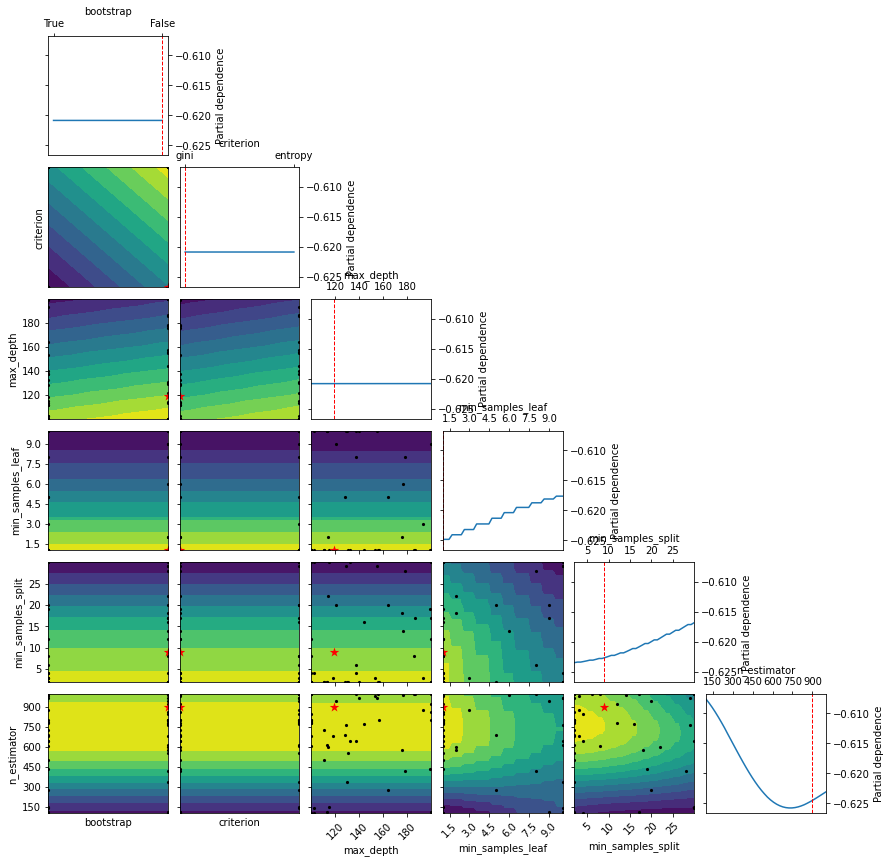

In [80]:
# plot_objective(opt.optimizer_results_[0],
#                    dimensions=[
#                     'bootstrap',
#                     'criterion',
#                     'max_depth',
#                     'min_samples_leaf',
#                     'min_samples_split',
#                     'n_estimator',
#                     # 'random_state',
#                     ],
#                    n_minimum_search=int(1e8))
# plt.show()

# Use Case with Modules


In [1]:
from project_module.message_classifier import MessageClassifier

In [2]:
message_classifier = MessageClassifier(auto_common= False)

In [3]:
message_classifier.load_model(model_path='./models/rf_model.joblib', json_classes_path='./classes.json')

In [14]:
print(message_classifier.classify(text_input='เข้าใจแล้วครับ'))

['C', 0.27444444444444444]


### Analyz Model

In [56]:
# result_data = pd.DataFrame(y_test.reset_index())

# result_data['message'] = [ data.loc[i]['message'] for i in result_data['index'] ]
# result_data['predict'] = message_classifier.predict(X_test)
# result_data['predict_proba'] = [ p for p in message_classifier.predict_proba(X_test) ]
# result_data['predict_sd'] = message_classifier.predict_sd(X_test)
# result_data.head()


In [57]:
# temp = result_data.drop(result_data.index[ result_data['category_target'] == result_data['predict'] ])
# temp.head()


In [58]:
# mean_error_sd =  temp['predict_sd'].mean()
# print(f'avg sd of wrong predict: {mean_error_sd}')

### Summary Final Result

['A', 'C', 'Q', 'S', 'T']

In [59]:
# def count_category(data):
#     count = [0, 0, 0, 0, 0]
    
#     for y in data:
#         count[y] += 1
    
#     return count

In [60]:
# y_result =  message_classifier.predict(X_test)


In [61]:
# print('Accuracy', accuracy_score(y_test, y_result))

# print(classification_report(y_test, y_result))

### Common Chat Accuracy Test

In [62]:
# # common chat data
# c_data = data.loc[data.index[ data['category'] == 'C' ]]
# c_data.head()

In [63]:
# X_temp = c_data['word2vec'].reset_index()
# X_temp.head()

### Auto common category Test

In [64]:
# #auto common 
# y_temp1 = [ message_classifier.predict(x)[0] for x in X_temp['word2vec'] ]
# print(f'Common Accuracy: {y_temp1.count(1)/len(y_temp1)}')

In [65]:
# # none auto common model
# custom_message_classifier = MessageClassifier(auto_common= False)
# custom_message_classifier.load_model(model_path='./models/rf_model.joblib', json_classes_path='./classes.json')

# y_temp2 = [ custom_message_classifier.predict(x)[0] for x in X_temp['word2vec'] ]
# print(f'Common Accuracy: {y_temp2.count(1)/len(y_temp2)}')

In [66]:
# for i in range(30, 80):
#     # tunning model
#     error_sd = 0.001 * i
#     custom_message_classifier = MessageClassifier(error_sd= error_sd)
#     custom_message_classifier.load_model(model_path='./models/rf_model.joblib', json_classes_path='./classes.json')

#     y_temp2 = custom_message_classifier.predict(X_test)
#     print(f'SD: {round(error_sd, 3)} | Accuracy: {accuracy_score(y_test, y_temp2)}')
#     # print('Accuracy', accuracy_score(y_test, y_temp2))
#     # print(classification_report(y_test, y_temp2))